Train images shape: (528, 64, 64, 3)
Train labels shape: (528,)
Test images shape: (132, 64, 64, 3)
Test labels shape: (132,)


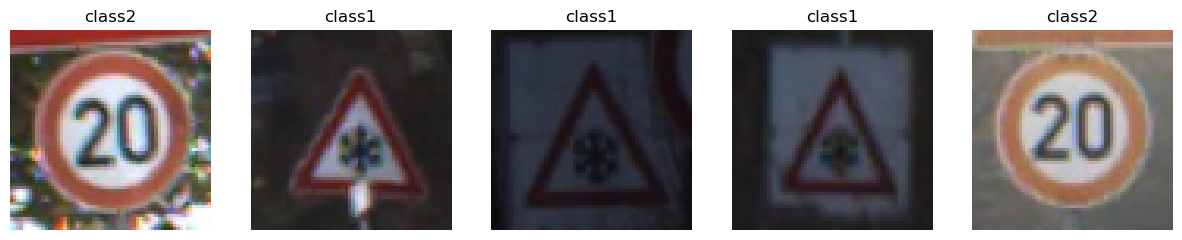

In [2]:
# Vanilla Neural Network

import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image


# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                filepath = os.path.join(label_folder, filename)
                if filename.endswith(".jpg"):
                    image = Image.open(filepath)
                    image = np.array(image)
                    images.append(image)
                    labels.append(label)  # Append folder name directly
    return np.array(images), np.array(labels)

# Path to the folder containing class folders
dataset_folder = "GTSRB_subset_2"

# Load images and labels
images, labels = load_images_from_folder(dataset_folder)

# Split the data into training and testing sets (80% training, 20% testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

# Print some sample images with labels
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(train_images[i])
    axes[i].set_title(train_labels[i])
    axes[i].axis('off')
plt.show()


In [ ]:
pip install torchvision

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn  # Import nn module from PyTorch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from PIL import Image

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                filepath = os.path.join(label_folder, filename)
                if filename.endswith(".jpg"):
                    image = Image.open(filepath)
                    image = ToTensor()(image)  # Convert image to tensor
                    images.append(image)
                    labels.append(label)  # Append folder name directly
    return images, labels



In [3]:
# Path to the folder containing class folders
dataset_folder = "GTSRB_subset_2"

# Load images and labels
images, labels = load_images_from_folder(dataset_folder)

# Convert labels to numerical values using label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets (80% training, 20% testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors and create DataLoader objects with reduced batch size
batch_size = 2  # Reduced batch size
train_loader = DataLoader(TensorDataset(torch.stack(train_images), torch.tensor(train_labels)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.stack(test_images), torch.tensor(test_labels)), batch_size=batch_size)



In [4]:
# Define the neural network class
class VanillaNN(nn.Module):
    def __init__(self):
        super(VanillaNN, self).__init__()
        self.fc1 = nn.Linear(64*64*3, 10)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(10, 10)       # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(10, 2)        # Second hidden layer to output layer

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first hidden layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second hidden layer
        x = self.fc3(x)  # Output layer (no activation for cross-entropy loss)
        return x

# Initialize the network
model = VanillaNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)



In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(labels.tolist())

# Calculate accuracy
accuracy = accuracy_score(all_targets, all_predictions)
print(f"Test set accuracy: {accuracy:.4f}")


In [1]:
# Convolution Neural Network-Pytorch Implementation

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 43)  # Output size is 43 for the GTSRB dataset

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    labels = []
    class_folders = sorted(os.listdir(folder))  # Ensure consistent ordering of classes
    label_encoder = LabelEncoder()
    label_encoder.fit(class_folders)
    for label in class_folders:
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                filepath = os.path.join(label_folder, filename)
                if filename.endswith(".jpg"):
                    image = Image.open(filepath)
                    image = ToTensor()(image)
                    images.append(image)
                    labels.append(label_encoder.transform([label])[0])  # Encode label
    return images, labels


# Path to the folder containing class folders
dataset_folder = "GTSRB_subset_2"

# Load images and labels
images, labels = load_images_from_folder(dataset_folder)

# Convert the data to PyTorch tensors
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(labels)

# Split the data into training and testing sets (80% training, 20% testing)
train_images, test_images, train_labels, test_labels = train_test_split(images_tensor, labels_tensor, test_size=0.2, random_state=42)

# Create DataLoader objects for training and testing sets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize the CNN model
model = CNN()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy().tolist())
        all_targets.extend(labels.cpu().numpy().tolist())

# Calculate accuracy
accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
print(f"Test set accuracy: {accuracy:.4f}")

Epoch [1/20], Loss: 3.5640
Epoch [2/20], Loss: 1.3031
Epoch [3/20], Loss: 0.8066
Epoch [4/20], Loss: 0.7615
Epoch [5/20], Loss: 0.7284
Epoch [6/20], Loss: 0.6911
Epoch [7/20], Loss: 0.6215
Epoch [8/20], Loss: 0.6609
Epoch [9/20], Loss: 0.5979
Epoch [10/20], Loss: 0.6709
Epoch [11/20], Loss: 0.5259
Epoch [12/20], Loss: 0.5093
Epoch [13/20], Loss: 0.6679
Epoch [14/20], Loss: 0.4912
Epoch [15/20], Loss: 0.5085
Epoch [16/20], Loss: 0.3740
Epoch [17/20], Loss: 0.3683
Epoch [18/20], Loss: 0.3787
Epoch [19/20], Loss: 0.3764
Epoch [20/20], Loss: 0.3096
Test set accuracy: 0.9167
